In [206]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from tensorflow.keras.callbacks import TensorBoard
import time

NAME = "Surface_CNN_64x2_{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='log/{}'.format(NAME))

In [207]:
# Load training data from 'X_train.csv' into numpy array. Delete the first row and the first column
X_data = np.genfromtxt('X_train.csv', delimiter=',', skip_header=1)
X_data = np.delete(X_data, 0, 1)
X_data

array([[ 0.0000e+00,  0.0000e+00, -7.5853e-01, ..., -7.4857e-01,
         2.1030e+00, -9.7532e+00],
       [ 0.0000e+00,  1.0000e+00, -7.5853e-01, ...,  3.3995e-01,
         1.5064e+00, -9.4128e+00],
       [ 0.0000e+00,  2.0000e+00, -7.5853e-01, ..., -2.6429e-01,
         1.5922e+00, -8.7267e+00],
       ...,
       [ 3.8090e+03,  1.2500e+02,  6.2891e-01, ...,  2.7048e+00,
         4.2622e+00, -8.1443e+00],
       [ 3.8090e+03,  1.2600e+02,  6.2903e-01, ...,  2.5410e+00,
         4.7130e+00, -9.4435e+00],
       [ 3.8090e+03,  1.2700e+02,  6.2915e-01, ...,  8.2391e-01,
         4.2751e+00, -1.0498e+01]])

In [208]:
'''
y_data = np.genfromtxt('y_train.csv', delimiter=',', skip_header=1, usecols=(0,1))
y_data
'''

"\ny_data = np.genfromtxt('y_train.csv', delimiter=',', skip_header=1, usecols=(0,1))\ny_data\n"

In [223]:
# Load the training labels from 'y_train.csv' into numpy array. 
# Replace the name of labels with numbers.
# 'carpet' => 0
# 'concrete' => 1
# 'fine_concrete' => 2
# 'hard_tiles' => 3
# 'hard_tiles_large_space' => 4
# 'soft_pvc' => 5
# 'soft_tiles' => 6
# 'tiled' => 7
# 'wood' => 8
y_label = np.genfromtxt('y_train.csv', dtype='str', delimiter=',', skip_header=1, usecols=(2))
y = np.unique(y_label, return_inverse=True)[1]
y

array([2, 1, 1, ..., 2, 7, 5], dtype=int64)

In [224]:
# Extract features from training data
X_feature = X_data[:, 2:]
np.shape(X_feature)

(487680, 10)

In [225]:
# Convert orientation features 
# from quaternion (orientation_W, orientation_X, orientation_Y, orientation_Z) 
# to euler angles (roll, pitch, yaw)
def q_to_angle(q_val):
    #We assume q_val is in this format: [qw, q1, q2, q3]
    #And the quaternion is normalized
    roll = np.arctan2(2*(q_val[0]*q_val[1] + q_val[2]*q_val[3]),1 - 2*(q_val[1]*q_val[1] + q_val[2]*q_val[2]))
    pitch = np.arcsin(2*(q_val[0]*q_val[2] - q_val[3]*q_val[1]))
    yaw = np.arctan2(2*(q_val[0]*q_val[3] + q_val[1]*q_val[2]),1 - 2*(q_val[2]*q_val[2] + q_val[3]*q_val[3]))
    return np.array([roll, pitch, yaw])

R_P_Y = []

for i in range(len(X_feature)):
    R_P_Y.append(q_to_angle([X_feature[i, 3], X_feature[i, 0], X_feature[i, 1], X_feature[i, 2]]))

R_P_Y = np.array(R_P_Y)
R_P_Y

array([[ 2.8432723 , -0.02466762,  1.39666401],
       [ 2.84319907, -0.02466201,  1.39664647],
       [ 2.84322377, -0.02472832,  1.39668201],
       ...,
       [ 2.90765693, -0.01869871, -1.76785591],
       [ 2.90747957, -0.01865525, -1.7675341 ],
       [ 2.90736503, -0.0186646 , -1.76719979]])

In [226]:
# Replace [orientation_W, orientation_X, orientation_Y, orientation_Z] with [roll, pitch, yaw]
X_feature[:, 0] = R_P_Y[:, 0]
X_feature[:, 1] = R_P_Y[:, 1]
X_feature[:, 2] = R_P_Y[:, 2]
X_feature = np.delete(X_feature, 3, 1)
np.shape(X_feature)

(487680, 9)

In [253]:
#Reshape features into 3810x128x9 nested array. (3810 series, 128 measurements per series, 9 features per measurement )
X = []

for i in range(len(y_label)):
    X.append(X_feature[(i*128):((i+1)*128), :])

X = np.array(X).reshape(-1, 128, 9)
X

array([[[ 2.84327230e+00, -2.46676154e-02,  1.39666401e+00, ...,
         -7.48570000e-01,  2.10300000e+00, -9.75320000e+00],
        [ 2.84319907e+00, -2.46620139e-02,  1.39664647e+00, ...,
          3.39950000e-01,  1.50640000e+00, -9.41280000e+00],
        [ 2.84322377e+00, -2.47283163e-02,  1.39668201e+00, ...,
         -2.64290000e-01,  1.59220000e+00, -8.72670000e+00],
        ...,
        [ 2.84215195e+00, -2.36391962e-02,  1.39333622e+00, ...,
         -9.81930000e-01,  9.73280000e-01, -9.97950000e+00],
        [ 2.84214068e+00, -2.35619899e-02,  1.39327083e+00, ...,
         -7.25910000e-01,  3.49310000e-01, -1.19770000e+01],
        [ 2.84232293e+00, -2.36388073e-02,  1.39323311e+00, ...,
         -5.34260000e-01,  8.03460000e-01, -1.06970000e+01]],

       [[ 2.84107449e+00, -1.15986595e-02, -4.90163967e-01, ...,
          2.18480000e+00,  2.25260000e+00, -8.95030000e+00],
        [ 2.84043537e+00, -1.17174267e-02, -4.90272005e-01, ...,
          4.99050000e-01,  2.97620000e

In [254]:
#Use the first order difference of 3 orientation features
#Absolute orientation features dont make sense to predict surface

for i in range(3):
    np_arr = X[:,:,i]
    roll_arr = np.copy(np_arr)
    roll_arr[:,1:] = roll_arr[:,:-1]
    np_arr = np_arr - roll_arr
    X[:,:,i] = np_arr
    
np.shape(X)

(3810, 128, 9)

In [255]:
#Normalize each 128-pt sample to ensure there is no group related information left in the samples

for i in range(3, 9):
    np_arr = X[:,:,i]
    mean_arr = np.mean(np_arr,1)
    mean_arr = np.expand_dims(mean_arr,1)
    mean_arr = np.repeat(mean_arr,128,1)
    np_arr = np_arr - mean_arr
    X[:,:,i] = np_arr
    
np.shape(X)

(3810, 128, 9)

In [256]:
#Further normalization across the entire dataset to ensure NN inputs are zero-mean and unit standard deviation

num_sensor = X.shape[2]
for i in range(num_sensor):
    mean_s = np.mean(X[:,:,i])
    sd_s = np.std(X[:,:,i])
    X[:,:,i] = (X[:,:,i]-mean_s)/sd_s
X

array([[[ 1.25566511e-04, -1.56790099e-03, -6.93865512e-04, ...,
         -5.43771568e-01, -4.14564665e-01, -1.52173302e-01],
        [-2.00818145e-01,  3.57302722e-02, -1.08367811e-03, ...,
          4.11227740e-02, -6.95239553e-01, -3.24906080e-02],
        [ 6.79281836e-02, -4.43049173e-01,  9.62011155e-05, ...,
         -2.83553445e-01, -6.54874308e-01,  2.08738230e-01],
        ...,
        [-6.35630851e-02,  1.08306761e+00, -3.49355354e-03, ...,
         -6.69162874e-01, -9.46049805e-01, -2.31739088e-01],
        [-3.08049681e-02,  5.12517975e-01, -2.14737226e-03, ...,
         -5.31595673e-01, -1.23960111e+00, -9.34048670e-01],
        [ 5.00241646e-01, -5.13064190e-01, -1.53254020e-03, ...,
         -4.28616398e-01, -1.02594288e+00, -4.84007987e-01]],

       [[ 1.25566511e-04, -1.56790099e-03, -6.93865512e-04, ...,
          1.10847534e+00, -2.42564517e-01,  1.54208978e-01],
        [-1.75360322e+00, -7.92391389e-01, -3.09564236e-03, ...,
          2.02671457e-01,  9.78584610e

In [257]:
X = np.array(X).reshape(-1, 128, 9, 1)
X

array([[[[ 1.25566511e-04],
         [-1.56790099e-03],
         [-6.93865512e-04],
         ...,
         [-5.43771568e-01],
         [-4.14564665e-01],
         [-1.52173302e-01]],

        [[-2.00818145e-01],
         [ 3.57302722e-02],
         [-1.08367811e-03],
         ...,
         [ 4.11227740e-02],
         [-6.95239553e-01],
         [-3.24906080e-02]],

        [[ 6.79281836e-02],
         [-4.43049173e-01],
         [ 9.62011155e-05],
         ...,
         [-2.83553445e-01],
         [-6.54874308e-01],
         [ 2.08738230e-01]],

        ...,

        [[-6.35630851e-02],
         [ 1.08306761e+00],
         [-3.49355354e-03],
         ...,
         [-6.69162874e-01],
         [-9.46049805e-01],
         [-2.31739088e-01]],

        [[-3.08049681e-02],
         [ 5.12517975e-01],
         [-2.14737226e-03],
         ...,
         [-5.31595673e-01],
         [-1.23960111e+00],
         [-9.34048670e-01]],

        [[ 5.00241646e-01],
         [-5.13064190e-01],
         [

In [258]:
X.shape[1:]

(128, 9, 1)

In [259]:
#x = np.sort(X_feature[:, 9])
#x

In [260]:
'''
X_feature_normed = normalize(X_feature, axis=0)
X_feature_normed
'''

'\nX_feature_normed = normalize(X_feature, axis=0)\nX_feature_normed\n'

In [261]:
#x = np.sort(X_feature_normed[:, 9])
#x

In [252]:
'''
X = []

for i in range(len(y_data)):
    X.append(X_feature_normed[(i*128):((i+1)*128), :])

X = np.array(X).reshape(-1, 128, 10, 1)
X.shape[1:]
'''

'\nX = []\n\nfor i in range(len(y_data)):\n    X.append(X_feature_normed[(i*128):((i+1)*128), :])\n\nX = np.array(X).reshape(-1, 128, 10, 1)\nX.shape[1:]\n'

Train on 3048 samples, validate on 762 samples
Epoch 1/20
3048/3048 [==============================] - 21s 7ms/sample - loss: 2.0024 - acc: 0.2451 - val_loss: 1.7564 - val_acc: 0.3346
Epoch 2/20
3048/3048 [==============================] - 21s 7ms/sample - loss: 1.7030 - acc: 0.3730 - val_loss: 1.4946 - val_acc: 0.3766
Epoch 3/20
3048/3048 [==============================] - 21s 7ms/sample - loss: 1.5235 - acc: 0.4603 - val_loss: 1.4114 - val_acc: 0.4344
Epoch 4/20
3048/3048 [==============================] - 20s 7ms/sample - loss: 1.4216 - acc: 0.4921 - val_loss: 1.4079 - val_acc: 0.4633
Epoch 5/20
3048/3048 [==============================] - 20s 7ms/sample - loss: 1.2967 - acc: 0.5413 - val_loss: 1.3596 - val_acc: 0.4436
Epoch 6/20
3048/3048 [==============================] - 21s 7ms/sample - loss: 1.1852 - acc: 0.5823 - val_loss: 1.3225 - val_acc: 0.4777
Epoch 7/20
3048/3048 [==============================] - 20s 7ms/sample - loss: 1.0892 - acc: 0.6214 - val_loss: 1.1726 - val_acc: 0

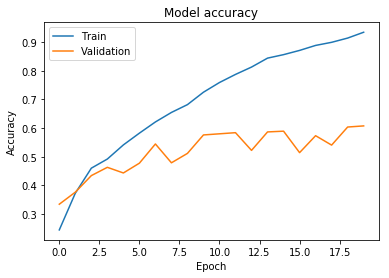

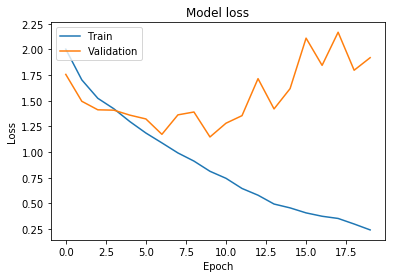

In [263]:
#Learn a CNN model
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = X.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(9))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



history = model.fit(X, y, batch_size=32, epochs=20, validation_split=0.2)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()